In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from sklearn.model_selection import train_test_split

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import time
key = random.PRNGKey(1)

In [ ]:
num_classes = 10
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

jit_ReLU = jit(ReLU)


def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

In [ ]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)


Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])
Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


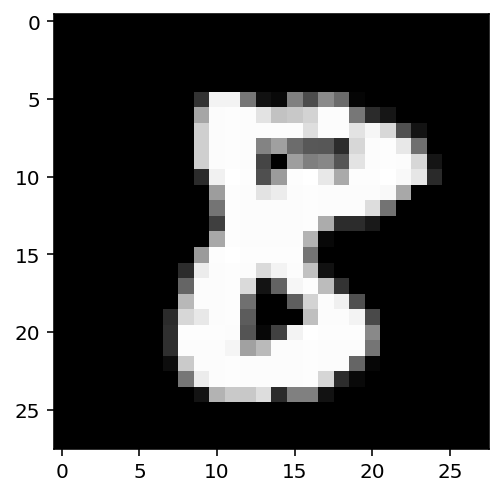

Label: 8


In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

We will need a function that initializes the weights in our MLP. We will pass a list of hidden layer sizes and the previously generated PRNG key. We need to split the key iteratively to generate the individual weights of our network.

In [ ]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

Now we define the forward pass through the network by iteratively looping over the layers and returning the log of the softmax output/predictions. Afterwards, we vmap the single case to create a batched version.

In [ ]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

# Now we need some gradient-sauce


In [ ]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)

def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(np.array(target), num_classes)

        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(batch_forward(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

We can now put things together into a single update function that computes the gradient of the loss with respect to the parameters for a batch. We use the predefined optimizers and choose Adam to be our optimizer for the initialized parameters and we are ready!


In [ ]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 10
num_classes = 10

Having setup everything - it is time to run the learning loop for the 2-layer NN!



In [ ]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))

    return train_loss, log_acc_train, log_acc_test


train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")


Epoch 1 | T: 23.97 | Train A: 0.973 | Test A: 0.968
Epoch 2 | T: 23.77 | Train A: 0.984 | Test A: 0.976
Epoch 3 | T: 22.89 | Train A: 0.985 | Test A: 0.974
Epoch 4 | T: 23.08 | Train A: 0.989 | Test A: 0.978
Epoch 5 | T: 22.76 | Train A: 0.995 | Test A: 0.982
Epoch 6 | T: 22.71 | Train A: 0.996 | Test A: 0.983
Epoch 7 | T: 22.60 | Train A: 0.996 | Test A: 0.980
Epoch 8 | T: 22.80 | Train A: 0.997 | Test A: 0.982
Epoch 9 | T: 22.79 | Train A: 0.994 | Test A: 0.977
Epoch 10 | T: 22.77 | Train A: 0.995 | Test A: 0.980


In [ ]:
def plot_mnist_performance(train_loss, train_acc, test_acc,
                           sup_title="Loss Curve"):
    """ Visualize the learning performance of a classifier on MNIST """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(train_loss)
    axs[0].set_xlabel("# Batch Updates")
    axs[0].set_ylabel("Batch Loss")
    axs[0].set_title("Training Loss")

    axs[1].plot(train_acc, label="Training")
    axs[1].plot(test_acc, label="Test")
    axs[1].set_xlabel("# Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Prediction Accuracy")
    axs[1].legend()

    # Give data more room to bloom!
    for i in range(2):
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)

    fig.suptitle(sup_title, fontsize=25)
    fig.tight_layout(rect=[0, 0.03, 1, 0.925])


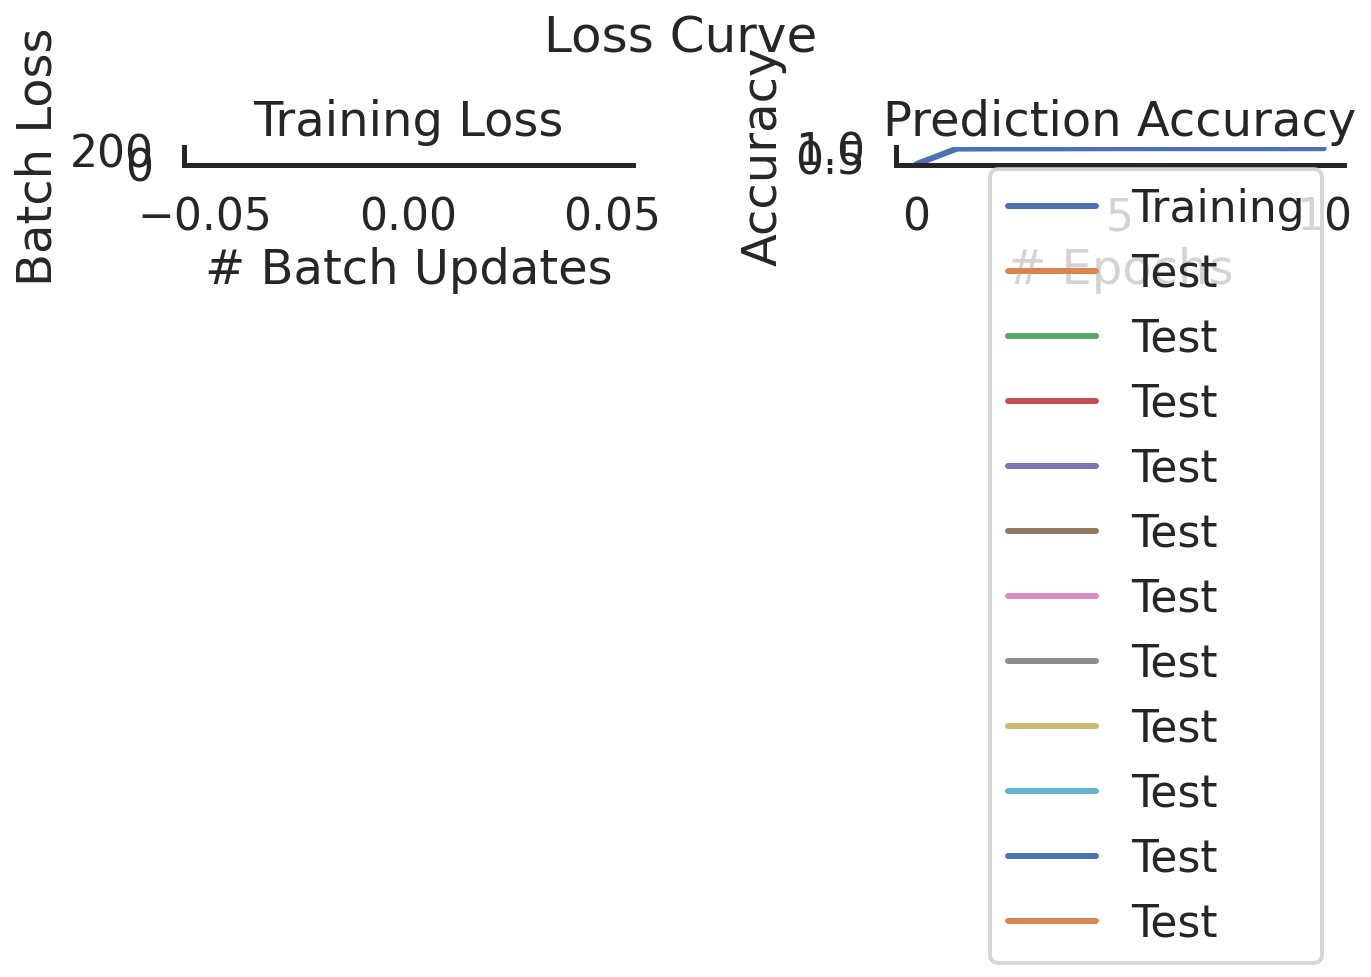

In [ ]:
plot_mnist_performance(train_loss, train_log, test_log)